## <font size=5> <strong> Groupe 4 - EI-2 DATA WEB - P\&G  </strong> </font>

## I. Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import os
print(os.listdir())

path="data/"

['.ipynb_checkpoints', 'binary-classification.ipynb', 'data', 'Documents', 'README.md', 'requirements.txt']


## II. Importation et compréhension des jeux de données

In [2]:

def importation(filename):
    """ 
    Cette fontion permet d'importer et lire les différents fichiers .csv contenant les datasets
    :input: csv_file
        un dataset fourni
    :output: dataframe
        une représentation en tableau (dataframe) du dataset
    """
    return pd.read_csv(path+filename, sep=",")

#dataframe de soumission
sub_sample = importation("DS_Centrale_submission_sample.csv")

#dataframe de "actions des consommateurs"
cons_actions = importation("DS_CentraleSupelec_consumeractions.csv")

#dataframe des données à tester
test = importation("DS_CentraleSupelec_test.csv").fillna(0)

#dataframe des données d'entrainement
train = importation("DS_CentraleSupelec_train.csv").fillna(0)

#dataframe sur la dureté de l'eau en fonction du département (échelle : 1: eau douce,...,4:eau très dure)
df_dure = pd.read_csv(path+"eauxdures.csv",sep=";")

train.head()

,userId,age,gender,registrationDate,languageCode,countryCode,emailContactable,postalContactable,postalCode,numberChildren,...,detergentType,MrPropreTrier,AntikalTrier,ArielTrier,DashTrier,scentLover,petOwner,ecoInterest,closestShop,washDishes
0,use_XbA1FTDcCrTMNTHK1851TzjyPMP,24.0,F,2019-10-14T17:33:37Z,fr,FRA,True,True,68540,1,...,Liquid,0,0,0,0,NonUser,Yes,0,0,Auto
1,use_3WHgsMVGSg5MHG2zja91TzdfmY2,67.0,F,2017-07-25T07:00:31Z,fr,FRA,True,True,17390,3,...,Pods,Known Trier,Known Trier,Known Trier,0,0,No,High,0,Auto
2,use_2SisOiR8QwDaHI4svm11TzcvK7V,45.0,F,2015-06-25T00:00:00Z,fr,FRA,True,True,30200,1,...,Liquid,0,0,Known Trier,Known Trier,NonUser,Yes,High,0,Auto
3,use_W0T1LmfKaQPJYD1RTWh1Tzdc69H,35.0,F,2018-01-31T07:24:39Z,fr,FRA,True,True,61400,2,...,Pods,0,0,Known Trier,Known Trier,Low,Yes,Medium,0,Hand
4,use_KwYWZ7UMl4veveOaPGK1TzddtmI,38.0,F,2016-01-26T11:42:17Z,fr,FRA,True,True,30620,0,...,Liquid,Known Trier,Known Trier,Known Trier,Known Trier,0,Yes,Low,0,Hand


In [3]:
def score_event(event):
    """
    Cette fonction permet de mettre un score sur les différents types 
    d'évenement que l'on peut retrouver dans le dataset 'consumeractions'
    :input: str
        un évenement (email open, email clicked...)
    :output: int
        un score compris entre 1 et 7 associé à l'évenement
    """
    s=0
    tokens=event.split()
    if "Email" in tokens:
        if "Opened" in tokens:
            s=1
        #email clicked
        else:
            s=2
    if "Product" in tokens: #Product Reviewed
        s=3
    if "Search" in tokens: #Search site
        s=4
    if "Coupon" in tokens:
        if "Request" in tokens:
            if "Print" in tokens:
                s=6
            #Request Coupon Add-to-basket
            else:
                s=5
        else:
            s=7
    return s

In [35]:
def postal_code_rank(df):
    """
    Cette fonction permet de regrouper les villes d'un même département (via leur code posta)
    et classer ensuite les départements en fonction de leur fréquence d'appairtion dans les datasets
    :input: dataframe
        le dataframe avec la colonne 'postalCode'
    :output: list
        une liste avec les départements classés et leur fréquence associée (liste de tuples)
    """
    dic_CP={}
            
    for j in range(len(df)):
        cp=df.iloc[j]['postalCode']
        if cp=="Nimes":
            dep=30
        else:
            dep=int(float(str(cp)[:2]))
            
        if dep in dic_CP:
            dic_CP[dep]+=1
        else:
            dic_CP[dep]=0
    
    return dic_CP

In [36]:
#mots clés associés au lave-vaisselle
key_words=['Fairy','PEPS','Platinum+']

In [37]:

# N.B : Cette fonction peut prendre 5-10 minutes pour calculer du fait du croisement avec le dataset 'consumeractions' 
# qui fait près de 1 millions de lignes pour les événements 

def clean_df_to_num(df_train,df_cons_act,data_type,filename,added_filters):
    """
    Cette fonction permet de générer un dataframe avec des données numériques 
    en appliquant différentes métriques pour chaque feature
    :input: dataframe, dataframe, str
        nous avons comme entrées, le dataframe à transformer numériquemement, le dataset 'consumeractions' 
        et savoir il s'agit de données d'entrainement ou de tests. Cette dernière options sert à juste nous dire 
        si on doit laisser la colonne 'washDishes' ou pas (dans le cas du dataset de test on l'enlève)
    :output: dataframe
        un score compris entre 1 et 7 associé à l'évenement
    """

    df_num=df_train[['age']]

    filters=['languageCode','countryCode','lastActivityDate','closestShop','registrationDate','detergentType']+added_filters

    feature_names=df_train.keys()[1:]
    # print(feature_names)
    for col in feature_names:
        if str(col) not in filters:
            df_num[col]=0
    for coll in ['liquidDetergent','podsDetergent','powderDetergent','pc_score','postalScore']:
        df_num[coll]=0
    
    #création de moyenne d'âge
    for i in range(len(df_train)):
        value=df_train.iloc[i]['age']
        if 10<=value<20:
            value=15
        if 20<=value<30:
            value=25
        if 30<=value<40:
            value=35
        if 40<=value<50:
            value=45
        if 50<=value<60:
            value=55
        if 60<=value<70:
            value=65
        if 70<=value<80:
            value=75
        if 80<=value<=90:
            value=85
        df_num.at[i,'age']=value
    
    df_num['score_event']=0
    
    #on garde la variable explicative pour l'entrainement
    if data_type=="training":
        df_num.loc[df_train.washDishes=="Auto",'washDishes']=1

    #on affecte nos métriques (binaire, échelle d'intensité de 1 à 4 ...)
    
    df_num.loc[df_train.gender=="F",'gender']=1
    df_num.loc[df_train.gender=="M",'gender']=0


    df_num.loc[df_train.ecoInterest=="Low",'ecoInterest']=1
    df_num.loc[df_train.ecoInterest=="Medium",'ecoInterest']=2
    df_num.loc[df_train.ecoInterest=="High",'ecoInterest']=3
    df_num.loc[df_train.ecoInterest=="Very high",'ecoInterest']=4


    df_num.loc[df_train.petOwner=="Yes",'petOwner']=1


    df_num.loc[df_train.MrPropreTrier=="Known Trier",'MrPropreTrier']=1
    df_num.loc[df_train.AntikalTrier=="Known Trier",'AntikalTrier']=1
    df_num.loc[df_train.ArielTrier=="Known Trier",'ArielTrier']=1
    df_num.loc[train.DashTrier=="Known Trier",'DashTrier']=1


    df_num.loc[df_train.toothBrushType=="Manual",'toothBrushType']=0
    df_num.loc[df_train.toothBrushType=="Electric",'toothBrushType']=1


    df_num.loc[df_train.emailContactable==True,'emailContactable']=1
    df_num.loc[df_train.postalContactable==True,'postalContactable']=1


    for i in range(17):
        
        if i < 5:
            df_num.loc[df_train.numberChildren==str(i),'numberChildren']=i

        else:
            df_num.loc[df_train.numberChildren==str(i),'numberChildren']=5

            
    df_num.loc[df_train.numberChildren=="4+",'numberChildren']=5
    df_num['numberChildren'] = pd.to_numeric(df_num['numberChildren'])

    
    df_num.loc[df_train.reactivationValue=="Lapsed",'reactivationValue']=3
    df_num.loc[df_train.reactivationValue=="Lapsing",'reactivationValue']=2
    df_num.loc[df_train.reactivationValue=="Dormant",'reactivationValue']=1
    df_num.loc[df_train.reactivationValue=="Active",'reactivationValue']=4


    df_num.loc[df_train.scentLover=="NonUser",'scentLover']=0
    df_num.loc[df_train.scentLover=="Low",'scentLover']=1
    df_num.loc[df_train.scentLover=="Medium",'scentLover']=2
    df_num.loc[df_train.scentLover=="High",'scentLover']=3



    for j in range(len(df_train)):
        cp=str(df_train.iloc[j]['postalCode'])
        
        # cas ou trouve le nom d'une ville dans code postal
        if cp=="Nimes":
            dep=30
        else:
            #département à un chiffre
            if len(cp)==4:
                dep=int(str(cp)[0])
            else:
                dep=int(str(cp)[:2])
            
            
        df_num.at[j,'postalCode']=dep
     
    
    dic_rank=postal_code_rank(df_num)
    
    for key in dic_rank:
        df_num.loc[df_num.postalCode==key,'postalScore']=dic_rank[key]
        
    
    
    # création de la colonne de la dureté de l'eau (new feature) en fonction du département
    for i in range(len(df_num)):
        
        dep=str(df_num["postalCode"][i])

        try:
            df_num['pc_score'][i]=df_dure[df_dure['Département']==dep].iloc[0]['Dureté']
        except:
            df_num['pc_score'][i]=0
    
    #on crée 3 colonnes différentes pour chaque type de détergents et on applique une métrique binaire
    for i in range(len(df_train)):
        value=df_train.iloc[i]['detergentType']
        if value!=0:
            value1=value.split(',')

            val_pods=0
            val_liq=0
            val_powd=0

            if 'Pods' in value1:
                val_pods=1
            if 'Liquid' in value1:
                val_liq=1
            if 'Powder' in value1:
                val_powd=1
                
            df_num.at[i,'liquidDetergent']=val_liq
            df_num.at[i,'podsDetergent']=val_pods
            df_num.at[i,'powderDetergent']=val_powd
            
            
    ## on rajoute une feature du dataset 'consumeractions'
    
    liste_userID=df_train['userId'].unique()
    dic_events={}
    
    for userId in liste_userID:
        dic_events[userId]=0
        
    df=df_cons_act    
    
    # on regarde si nous avons des mots clés sur les laves-vaisselles (les key-words plus haut) ject line'
    # et on regarde les évènements associés puis on attribut un score global par utilisateur
    for i in range(len(df)): 
        bd=df.iloc[i]['brandName']
        subject=df.iloc[i]['subjectLine']
        
        status=False
        try:
            if any(word in bd.split() for word in key_words) :
                status=True
        except:
            None
        try:
            if any(word in subject.split() for word in key_words):
                status=True
        except:
            None
        if status==True:
            try:
                dic_events[df.iloc[i]['userId']] += score_event(df.iloc[i]['event'])      
                
            except:
                None
         
    for i in range(len(df_num)):
        
        keyID=df_train.iloc[i]['userId']
        if keyID in dic_events:
            df_num.at[i,'score_event']=dic_events[keyID]
    
    
    f = open(filename, 'r+')
    f.truncate(0)
    df_num.to_csv(filename)


In [7]:
##### N.B1 : N'exécuter cette cellule que s'ils faut mettre à jour le dataset d'entrainement    #####
# par exemple, s'il y a eu un changement de métrique, une feature rajoutée...
# Exécuter uniquement la cellule suivante qui va importer le dataset numérique générée par la cellule actuelle

clean_df_to_num(train,cons_actions,"training",path+'DS_num_train.csv',[])

<ipython-input-6-021a333ebf36>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[col]=0
<ipython-input-6-021a333ebf36>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[coll]=0
<ipython-input-6-021a333ebf36>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-6-021a333ebf36>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num.loc[df_num.postalCode==key,'postalScore']=dic_rank[key]
<ipython-input-7-9470a7187ab9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_to_num(train,cons_actions,"training",path+'DS_num_train.csv',[])


In [8]:
#dataframe numérique sur les données d'entrainement
df_num=importation("DS_num_train.csv")
df_num.head()

,Unnamed: 0,age,gender,emailContactable,postalContactable,postalCode,numberChildren,reactivationValue,toothBrushType,MrPropreTrier,...,scentLover,petOwner,ecoInterest,washDishes,liquidDetergent,podsDetergent,powderDetergent,pc_score,postalScore,score_event
0,0,25,1,1,1,68,1,2,0,0,...,0,1,0,1,1,0,0,2,113,0
1,1,65,1,1,1,17,3,4,0,1,...,0,0,3,1,0,1,0,3,106,1
2,2,45,1,1,1,30,1,4,0,0,...,0,1,3,1,1,0,0,3,124,0
3,3,35,1,1,1,61,2,4,0,0,...,1,1,2,0,0,1,0,3,70,0
4,4,35,1,1,1,30,0,4,1,1,...,0,1,1,0,1,0,0,3,124,0


#### Taille du dataset

In [9]:
df_num.shape

(12000, 23)

#### Affichage de certaines lignes

In [10]:
df_num.sample(5)

,Unnamed: 0,age,gender,emailContactable,postalContactable,postalCode,numberChildren,reactivationValue,toothBrushType,MrPropreTrier,...,scentLover,petOwner,ecoInterest,washDishes,liquidDetergent,podsDetergent,powderDetergent,pc_score,postalScore,score_event
5405,5405,35,1,0,1,44,0,3,0,0,...,2,0,2,1,0,1,0,2,260,0
9325,9325,45,1,1,1,59,4,4,0,0,...,2,1,3,1,0,1,0,4,808,0
3107,3107,55,1,1,1,20,2,4,0,1,...,0,0,3,1,0,1,0,0,10,0
691,691,35,1,1,1,93,2,4,0,1,...,0,0,1,0,0,1,0,3,242,0
4899,4899,45,1,1,1,38,1,3,0,0,...,3,1,3,0,0,1,0,4,165,0


#### Description

In [11]:
df_num.describe()

,Unnamed: 0,age,gender,emailContactable,postalContactable,postalCode,numberChildren,reactivationValue,toothBrushType,MrPropreTrier,...,scentLover,petOwner,ecoInterest,washDishes,liquidDetergent,podsDetergent,powderDetergent,pc_score,postalScore,score_event
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,40.678417,0.866083,0.880167,0.89400,51.768583,1.275583,3.369667,0.340333,0.171000,...,0.529750,0.600417,1.370083,0.382000,0.500583,0.348083,0.037750,2.581667,231.882167,0.682833
std,3464.24595,14.446351,0.340577,0.324780,0.30785,26.970517,1.294454,1.057090,0.473841,0.376525,...,0.912607,0.489833,1.314065,0.485897,0.500020,0.476382,0.190599,1.075683,199.990994,1.905748
min,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,2999.75000,35.000000,1.000000,1.000000,1.00000,31.000000,0.000000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,107.000000,0.000000
50%,5999.50000,35.000000,1.000000,1.000000,1.00000,58.000000,1.000000,4.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3.000000,188.000000,0.000000
75%,8999.25000,45.000000,1.000000,1.000000,1.00000,74.000000,2.000000,4.000000,1.000000,0.000000,...,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,3.000000,242.000000,0.000000
max,11999.00000,95.000000,1.000000,1.000000,1.00000,98.000000,5.000000,4.000000,1.000000,1.000000,...,3.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,4.000000,808.000000,47.000000


In [12]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Unnamed: 0         12000 non-null  int64
 1   age                12000 non-null  int64
 2   gender             12000 non-null  int64
 3   emailContactable   12000 non-null  int64
 4   postalContactable  12000 non-null  int64
 5   postalCode         12000 non-null  int64
 6   numberChildren     12000 non-null  int64
 7   reactivationValue  12000 non-null  int64
 8   toothBrushType     12000 non-null  int64
 9   MrPropreTrier      12000 non-null  int64
 10  AntikalTrier       12000 non-null  int64
 11  ArielTrier         12000 non-null  int64
 12  DashTrier          12000 non-null  int64
 13  scentLover         12000 non-null  int64
 14  petOwner           12000 non-null  int64
 15  ecoInterest        12000 non-null  int64
 16  washDishes         12000 non-null  int64
 17  liquidDeterg

#### Analyse de la variable à expliquer

In [13]:
df_num["washDishes"].describe()

count    12000.000000
mean         0.382000
std          0.485897
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: washDishes, dtype: float64

In [14]:
df_num["washDishes"].unique()

array([1, 0], dtype=int64)

### Corrélation des features

In [15]:
print(df_num.corr()["washDishes"].abs().sort_values(ascending=False))

washDishes           1.000000
numberChildren       0.154992
age                  0.153612
toothBrushType       0.111456
ecoInterest          0.109189
score_event          0.099711
petOwner             0.097935
reactivationValue    0.092396
postalContactable    0.082962
postalScore          0.077483
emailContactable     0.073574
podsDetergent        0.048025
gender               0.047276
scentLover           0.038834
ArielTrier           0.034418
AntikalTrier         0.026565
DashTrier            0.021948
postalCode           0.020273
MrPropreTrier        0.017828
pc_score             0.014453
Unnamed: 0           0.011538
liquidDetergent      0.008464
powderDetergent      0.004458
Name: washDishes, dtype: float64


## Analyse des données

### Analyse de la variable 'washDishes'

0    7416
1    4584
Name: washDishes, dtype: int64


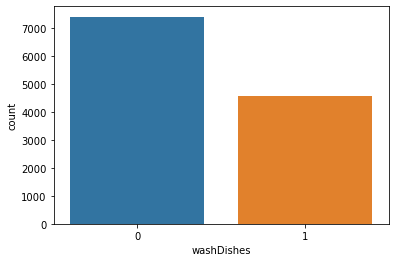

In [16]:
y = df_num["washDishes"]

sns.countplot(y)

target_temp = df_num.washDishes.value_counts()

print(target_temp)

In [17]:
print("Pourcentage de personnes lavant sa vaisselle à la main"+str(round(target_temp[0]*100/12000,2)))
print("Pourcentage de personnes ayant un lave-vaisselle "+str(round(target_temp[1]*100/12000,2)))


Pourcentage de personnes lavant sa vaisselle à la main61.8
Pourcentage de personnes ayant un lave-vaisselle 38.2


### Analyse de la feature 'âge'

In [18]:
df_num["age"].unique()

array([25, 65, 45, 35, 55, 75,  0, 85, 15, 95, 91, 93, 94], dtype=int64)

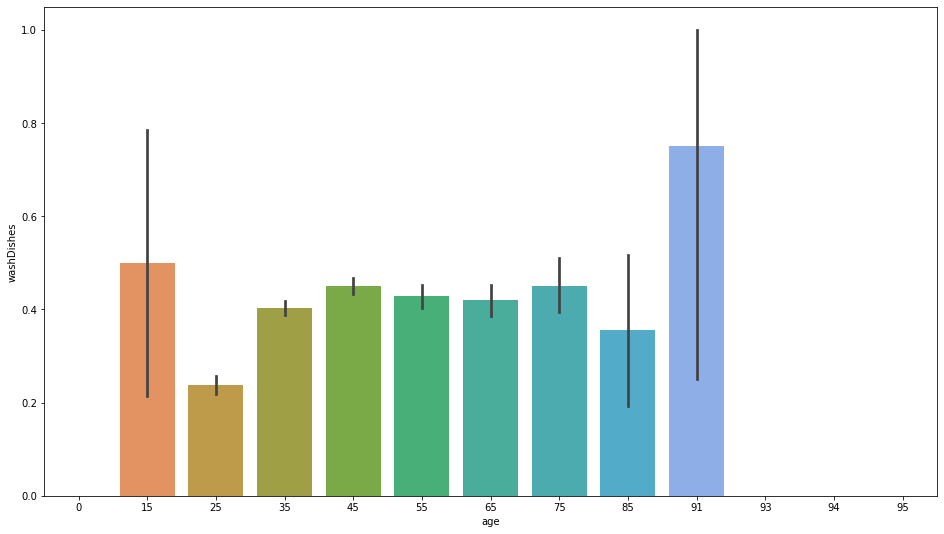

In [19]:
plt.figure(figsize=(16,9))
sns.barplot(df_num["age"],y)

### Analyse de la feature 'ecoInterest'

In [20]:
df_num["ecoInterest"].unique()

array([0, 3, 2, 1, 4], dtype=int64)

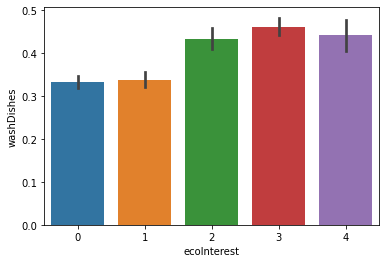

In [21]:
sns.barplot(df_num["ecoInterest"],y)

##### We notice, that chest pain of '0', i.e. the ones with typical angina are much less likely to have heart problems

### Analyse de la feature 'gender'

In [22]:
df_num["gender"].unique()

array([1, 0], dtype=int64)

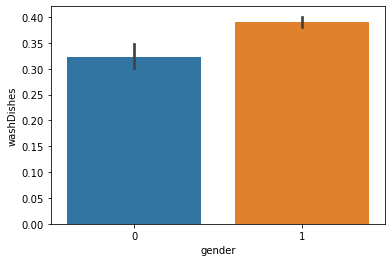

In [23]:
sns.barplot(df_num["gender"],y)

### Analyse de la feature 'toothBrushType'

In [24]:
df_num["toothBrushType"].unique()

array([0, 1], dtype=int64)

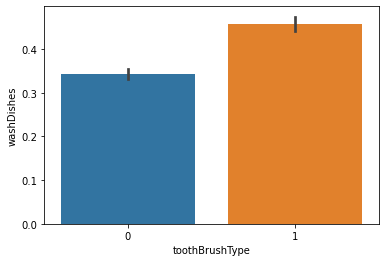

In [25]:
sns.barplot(df_num["toothBrushType"],y)

### Analyse de la feature 'reactivationValue'

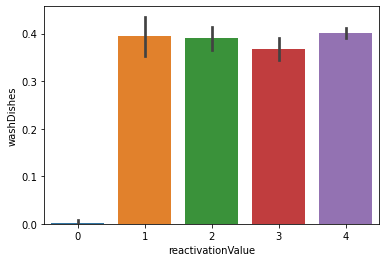

In [26]:
df_num["reactivationValue"].unique()
sns.barplot(df_num["reactivationValue"],y)

### Analyse de la feature 'postalCode' avec département uniquement

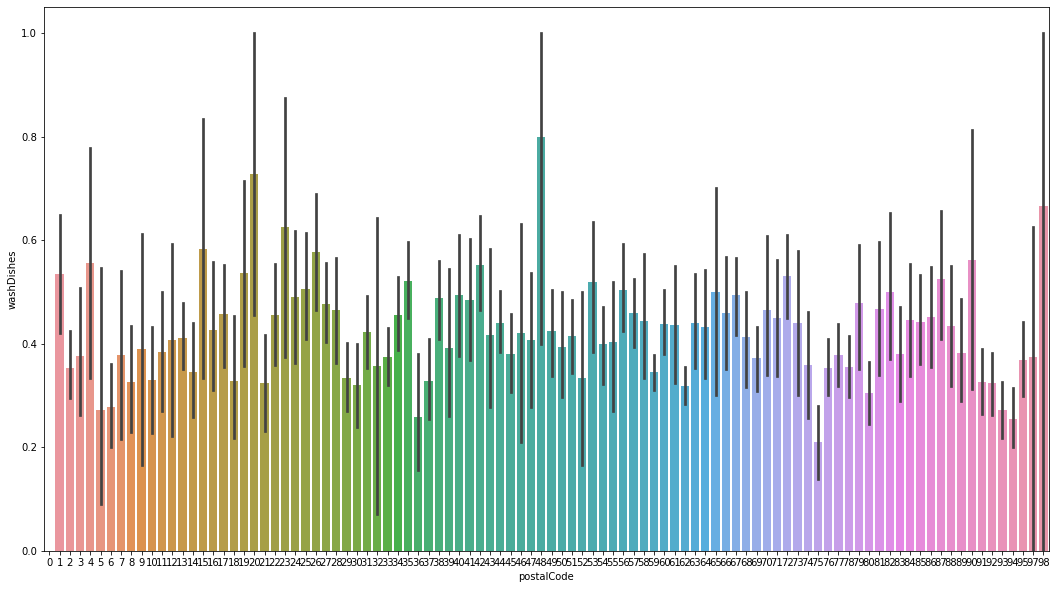

In [27]:
df_num["postalCode"].unique()
plt.figure(figsize=(18,10))
sns.barplot(df_num["postalCode"],y)

## IV. Phase d'apprentissage

In [38]:
from sklearn.model_selection import train_test_split

#filtres = features non utilisés
filters=['podsDetergent' ,'gender','postalCode','pc_score','scentLover','ArielTrier' ,'AntikalTrier','DashTrier' ,'MrPropreTrier','liquidDetergent','powderDetergent']

# données d'entrainements
predictors = df_num.drop(filters+['washDishes'],axis=1)
target = df_num["washDishes"]

X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)


In [163]:
X_train.shape

(9600, 10)

In [164]:
X_test.shape

(2400, 10)

In [165]:
Y_train.shape

(9600,)

In [166]:
Y_test.shape

(2400,)

In [40]:
##### N.B : N'exécuter cette cellule que si vous avait chnagé les filtres car le calcul prend aussi entre 5-10 minutes. #####

# dataset de tests (qui sera à soumettre)
clean_df_to_num(test,cons_actions,"test",path+'DS_num_test.csv',filters)

<ipython-input-37-021a333ebf36>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[col]=0
<ipython-input-37-021a333ebf36>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[coll]=0
<ipython-input-37-021a333ebf36>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [42]:
# dataset de tests directement utilisable
df_test=importation("DS_num_test.csv").fillna(0)
df_test.head()

,Unnamed: 0,age,emailContactable,postalContactable,numberChildren,reactivationValue,toothBrushType,petOwner,ecoInterest,liquidDetergent,...,pc_score,postalScore,score_event,gender,MrPropreTrier,AntikalTrier,ArielTrier,DashTrier,scentLover,postalCode
0,0,35,1,1,5,4,0,0,3,1,...,0,325,0,1.0,1.0,0.0,1.0,0.0,0.0,59.0
1,1,45,1,1,2,2,0,1,3,1,...,0,65,0,1.0,0.0,0.0,1.0,0.0,0.0,67.0
2,2,25,0,1,1,4,0,1,0,1,...,0,179,0,1.0,0.0,0.0,0.0,1.0,0.0,62.0
3,3,65,1,1,3,4,0,0,0,1,...,0,53,4,1.0,1.0,0.0,0.0,1.0,0.0,85.0
4,4,45,1,1,2,4,0,1,2,0,...,0,95,7,1.0,0.0,0.0,1.0,1.0,0.0,44.0


In [43]:
def generate_csv_submission(filename, Y):
    """
    Cette fonction permet de générer un fichier csv contenant les résultats obtenus 
    afin de les soumettre sur Kaggle au bon format
    :input: file, array
        fichier sur lequel écrire, listes des résultats prédits (Y)
    :output: None
        création du fichier résultat dans le répertoire "data"
    """
    file = open(filename + ".csv", 'w')
    with open("data/DS_Centrale_submission_sample.csv", 'r') as filin:
        i = 0
        line = filin.readline()
        file.write(line)
        while line != "" and i < len(Y):
            line = filin.readline()
            line_splited = line.split(",")
            if Y[i] == 0:
                line_splited[1] = 'Hand\n'
            new_line = line_splited[0] + "," + line_splited[1]
            file.write(new_line) 
            i += 1
        file.close()       




## V. Modèle statistiques utilisés

In [44]:
from sklearn.metrics import accuracy_score,confusion_matrix

### Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,Y_train)

Y_pred_lr = lr.predict(X_test)

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
Y_pred_lr.shape

(2400,)

In [47]:
score_lr = round(accuracy_score(Y_pred_lr,Y_test)*100,2)
print("The accuracy score achieved using Logistic Regression is: "+str(score_lr)+" %")
conf = confusion_matrix(Y_test,Y_pred_lr )
conf

The accuracy score achieved using Logistic Regression is: 64.21 %


array([[1302,  201],
       [ 658,  239]], dtype=int64)

In [172]:
import collections
df_test.shape
Y_real_lr = lr.predict(df_test)
print(collections.Counter(Y_real_lr))


Counter({0: 3021, 1: 979})


In [100]:
generate_csv_submission("data/test_lr", Y_real_lr)

### Naive Bayes

In [101]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_train,Y_train)

Y_pred_nb = nb.predict(X_test)
Y_pred_nb.shape

(2400,)

In [102]:
score_nb = round(accuracy_score(Y_pred_nb,Y_test)*100,2)
print("The accuracy score achieved using Logistic Regression is: "+str(score_nb)+" %")
conf = confusion_matrix(Y_test,Y_pred_nb )
conf

The accuracy score achieved using Logistic Regression is: 63.75 %


array([[1230,  273],
       [ 597,  300]], dtype=int64)

In [103]:
import collections
df_test.shape
Y_real_nb = nb.predict(df_test)
print(collections.Counter(Y_real_nb))


Counter({0: 2962, 1: 1038})


In [104]:
# import csv
# path='data/'
# def write_csv_sub(filename,Y):


#     fichier = open(path+filename,'rb')
#     fichiercsv = csv.reader(fichier, delimiter=',')

#     i = 0
#     for ligne in fichiercsv:
#         if Y[i]==0:
#             ligne[1]=ligne[1].replace("Auto", "Hand")
#         i += 1
#     fichier.close()

# write_csv_sub("DS_Centrale_submission_sample.csv", Y_real)


generate_csv_submission("data/test_nb", Y_real_nb)

### SVM

In [105]:
from sklearn import svm
#rbf
sv = svm.SVC(kernel='rbf')

sv.fit(X_train, Y_train)

Y_pred_svm = sv.predict(X_test)

In [106]:
Y_pred_svm.shape

(2400,)

In [107]:
score_svm = round(accuracy_score(Y_pred_svm,Y_test)*100,2)

print("The accuracy score achieved using Linear SVM is: "+str(score_svm)+" %")

The accuracy score achieved using Linear SVM is: 62.62 %


In [108]:
import collections
df_test.shape
Y_real_svm = svm.predict(df_test)
print(collections.Counter(Y_real_svm))

AttributeError: module 'sklearn.svm' has no attribute 'predict'

### K Nearest Neighbors

In [109]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train,Y_train)
Y_pred_knn=knn.predict(X_test)

In [110]:
Y_pred_knn.shape

(2400,)

In [111]:
score_knn = round(accuracy_score(Y_pred_knn,Y_test)*100,2)

print("The accuracy score achieved using KNN is: "+str(score_knn)+" %")

The accuracy score achieved using KNN is: 60.88 %


### Decision Tree

In [112]:
from sklearn.tree import DecisionTreeClassifier

max_accuracy = 0


for x in range(200):
    dt = DecisionTreeClassifier(random_state=x)
    dt.fit(X_train,Y_train)
    Y_pred_dt = dt.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_dt,Y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
#print(max_accuracy)
#print(best_x)


dt = DecisionTreeClassifier(random_state=best_x)
dt.fit(X_train,Y_train)
Y_pred_dt = dt.predict(X_test)

In [113]:
print(Y_pred_dt.shape)

(2400,)


In [114]:
score_dt = round(accuracy_score(Y_pred_dt,Y_test)*100,2)

print("The accuracy score achieved using Decision Tree is: "+str(score_dt)+" %")

The accuracy score achieved using Decision Tree is: 63.88 %


### Random Forest

In [115]:
from sklearn.ensemble import RandomForestClassifier

max_accuracy = 0


for x in range(100):
    rf = RandomForestClassifier(random_state=x)
    rf.fit(X_train,Y_train)
    Y_pred_rf = rf.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_rf,Y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
#print(max_accuracy)
#print(best_x)

rf = RandomForestClassifier(random_state=best_x)
rf.fit(X_train,Y_train)
Y_pred_rf = rf.predict(X_test)

KeyboardInterrupt: 

In [ ]:
Y_pred_rf.shape

In [88]:
score_rf = round(accuracy_score(Y_pred_rf,Y_test)*100,2)

print("The accuracy score achieved using Random Forest is: "+str(score_rf)+" %")

The accuracy score achieved using Random Forest is: 59.42 %


### XGBoost

In [116]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=1)

xgb_model.fit(X_train, Y_train)

Y_pred_xgb = xgb_model.predict(X_test)

D:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:58:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [117]:
score_xgb = round(accuracy_score(Y_pred_xgb,Y_test)*100,2)

print("The accuracy score achieved using XGBoost is: "+str(score_xgb)+" %")
print(collections.Counter(Y_pred_xgb))


Y_test_pred_xgb = xgb_model.predict(df_test)

print(confusion_matrix(Y_test, Y_pred_xgb))
print(collections.Counter(Y_test_pred_xgb))


generate_csv_submission("data/xgboost_6feats", Y_test_pred_xgb)

The accuracy score achieved using XGBoost is: 64.04 %
Counter({0: 1940, 1: 460})
[[1290  213]
 [ 650  247]]
Counter({0: 3131, 1: 869})


In [75]:
Y_pred_xgb.shape

(2400,)

In [76]:
score_xgb = round(accuracy_score(Y_pred_xgb,Y_test)*100,2)

print("The accuracy score achieved using XGBoost is: "+str(score_xgb)+" %")

The accuracy score achieved using XGBoost is: 63.67 %


### Neural Network

In [51]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(42, 14), random_state=1, max_iter=1000)

In [59]:
scores = cross_val_score(clf, X_train, Y_train, cv=10)

#Affichage des résultats

print ("Le score obtenu pour chacun des 5 fold créé est : ",scores)
print ("Cela fait une moyenne de : ",scores.mean())
print ("Et un écart-type de  : ",scores.std())

D:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the nu

Le score obtenu pour chacun des 5 fold créé est :  [0.63958333 0.640625   0.65       0.625      0.62708333 0.63645833
 0.64791667 0.640625   0.64479167 0.63854167]
Cela fait une moyenne de :  0.6390625
Et un écart-type de  :  0.00764401658706556


In [52]:
clf.fit(X_train, Y_train)

predictions = clf.predict(X_test)

print(collections.Counter(predictions))
print(accuracy_score(Y_test, predictions))

Counter({0: 1952, 1: 448})
0.6495833333333333


In [53]:
Y_test_pred = clf.predict(df_test)

print(collections.Counter(Y_test_pred))

generate_csv_submission("data/res_neuronnes", Y_test_pred)

Counter({0: 3202, 1: 798})


## VI. Output final score

In [ ]:
scores = [score_lr,score_nb,score_svm,score_knn,score_dt,score_rf,score_xgb,score_nn]
algorithms = ["Logistic Regression","Naive Bayes","Support Vector Machine","K-Nearest Neighbors","Decision Tree","Random Forest","XGBoost","Neural Network"]    

for i in range(len(algorithms)):
    print("The accuracy score achieved using "+algorithms[i]+" is: "+str(scores[i])+" %")

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")

sns.barplot(algorithms,scores)

## VII. BONUS

In [21]:
def cluster_df_to_num(df_cons_act,filename):
    """
    Cette fonction permet de générer un dataframe avec des données numériques 
    en appliqaunt différentes métriques pour chaque feature
    :input: dataframe, dataframe, str
        nous avons comme entrées, le dataframe à transformer numériquemement, le dataset 'consumeractions' 
        et savoir il s'agit de données d'entrainement ou de tests. Cette dernière options sert à juste nous dire 
        si on doit laisser la colonne 'washDishes' ou pas (dans le cas du dataset de test on l'enlève)
    :output: dataframe
        un score compris entre 1 et 7 associé à l'évenement
    """
    
    L_userId=df_cons_act['userId'].unique()
    n=len(L_userId)
    
    df_num=pd.DataFrame(columns=['userId','emailOpened','emailClicked','productReviewed','searchSite','RCAD','RCP','couponRed','score_event'],index=range(n))
    
    dic_score_events={}
    dic_EO={}
    dic_EC={}
    dic_PR={}
    dic_SS={}
    dic_RCAD={}
    dic_RCP={}
    dic_CP={}
    
    for i in range(len(L_userId)):
        df_num.at[i,'userId']=L_userId[i]
        dic_score_events[L_userId[i]]=0
        dic_EO[L_userId[i]]=0
        dic_EC[L_userId[i]]=0
        dic_PR[L_userId[i]]=0
        dic_SS[L_userId[i]]=0
        dic_RCAD[L_userId[i]]=0
        dic_RCP[L_userId[i]]=0
        dic_CP[L_userId[i]]=0
    
    for i in range(len(df_cons_act)):
        
        event=df_cons_act.iloc[i]['event']
        tokens=event.split()
        
        if "Email" in tokens:
            if "Opened" in tokens:
                dic_EO[df_cons_act.iloc[i]['userId']]+=1
            #email clicked
            else:
                dic_EC[df_cons_act.iloc[i]['userId']]+=1
        if "Product" in tokens: #Product Reviewed
            dic_PR[df_cons_act.iloc[i]['userId']]+=1
        if "Search" in tokens: #Search site
            dic_SS[df_cons_act.iloc[i]['userId']]+=1
        if "Coupon" in tokens:
            if "Request" in tokens:
                if "Print" in tokens:
                    dic_RCP[df_cons_act.iloc[i]['userId']]+=1
                #Request Coupon Add-to-basket
                else:
                    dic_RCAD[df_cons_act.iloc[i]['userId']]+=1
        else:
            dic_CP[df_cons_act.iloc[i]['userId']]+=1
            
        dic_score_events[df_cons_act.iloc[i]['userId']] += score_event(event)

    for keyID in dic_score_events:
        
        df_num[df_num['userId']==keyID].at[0,'score_event']=dic_events[keyID]
        df_num[df_num['userId']==keyID].at[0,'emailOpened']=dic_EO[keyID]
        df_num[df_num['userId']==keyID].at[0,'emailClicked']=dic_events[keyID]
        df_num[df_num['userId']==keyID].at[0,'productReviewed']=dic_events[keyID]
        df_num[df_num['userId']==keyID].at[0,'searchSite']=dic_events[keyID]
        df_num[df_num['userId']==keyID].at[0,'RCAD']=dic_events[keyID]
        df_num[df_num['userId']==keyID].at[0,'RCP']=dic_events[keyID]
        df_num[df_num['userId']==keyID].at[0,'couponRed']=dic_events[keyID]
    
    
    numpy.where(df['A'] < 5)[0]
          

    f = open(filename, 'r+')
    f.truncate(0)
    df_num.to_csv(filename)
    
    return df_num

In [ ]:
##### N.B : N'exécuter cette cellule que si vous avait changé les features ou métriques car le calcul prend aussi entre 5-10 minutes. #####


cluster_df_to_num(cons_actions,'DS_num_Clustering_Bonus.csv')

In [22]:
df_cluster=importation('DS_num_Clustering_Bonus.csv')
df_cluster.head()

nan


NameError: name 'dic_events' is not defined